Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

In [23]:
# Get all the library versions
from platform import python_version
import tensorflow as tf
print('Library Versions:')
print('Python:',python_version(),'| Numpy:',np.__version__,'| Pandas:',pd.__version__, '| Tensorflow:', tf.__version__)

Library Versions:
Python: 3.11.3 | Numpy: 1.24.3 | Pandas: 1.5.3 | Tensorflow: 2.15.0


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Dataset/Train")
data_dir_test = pathlib.Path('Dataset/Test')

In [66]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [70]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [71]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [72]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [73]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

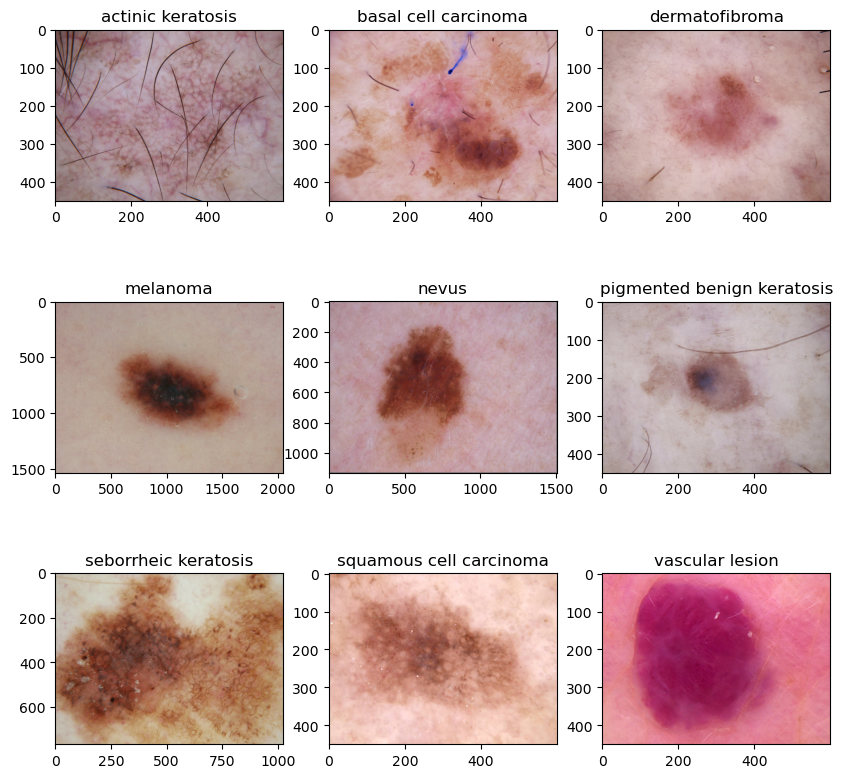

In [74]:
import matplotlib.pyplot as plt

### Using training or validation data to visualize
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [75]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [76]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define image dimensions
img_height = 180
img_width = 180
num_classes = 9

# Define the CNN model architecture
model = Sequential([
    # Rescale pixel values
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),

    # Convolutional layers
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten layer and fully connected layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [77]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [78]:
# View the summary of all layers
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 45, 45, 128)      

### Train the model

In [79]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 43s 667ms/step - loss: 2.2194 - accuracy: 0.2210 - val_loss: 1.8173 - val_accuracy: 0.3311
Epoch 2/30
56/56 [==============================] - 38s 671ms/step - loss: 1.7886 - accuracy: 0.3387 - val_loss: 1.7300 - val_accuracy: 0.3423
Epoch 3/30
56/56 [==============================] - 38s 685ms/step - loss: 1.6637 - accuracy: 0.4057 - val_loss: 1.5600 - val_accuracy: 0.4385
Epoch 4/30
56/56 [==============================] - 39s 701ms/step - loss: 1.5071 - accuracy: 0.4704 - val_loss: 1.4068 - val_accuracy: 0.4922
Epoch 5/30
56/56 [==============================] - 39s 697ms/step - loss: 1.4108 - accuracy: 0.5000 - val_loss: 1.3931 - val_accuracy: 0.5347
Epoch 6/30
56/56 [==============================] - 39s 695ms/step - loss: 1.3661 - accuracy: 0.5167 - val_loss: 1.6562 - val_accuracy: 0.4586
Epoch 7/30
56/56 [==============================] - 39s 700ms/step - loss: 1.3076 - accuracy: 0.5385 - val_loss: 1.4074 - val_accuracy: 0.4944

### Visualizing training results

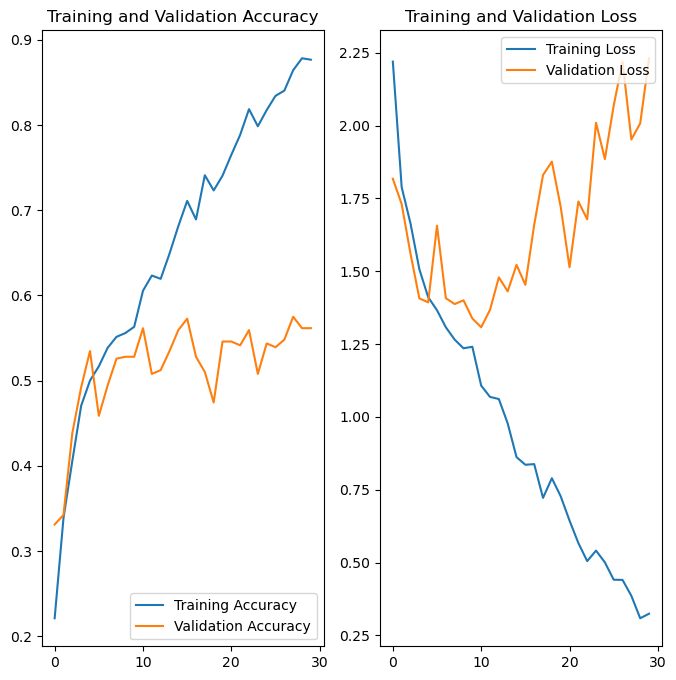

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

- The training accuracy continues to increase while the validation accuracy plateaus or decreases, it indicates overfitting.
- The model is overfitting because we can also see difference in loss functions in training & test around the 10-12th epoch.

### Data Augmentation

In [81]:
data_augment = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    layers.experimental.preprocessing.RandomRotation(factor=0.2),  # Randomly rotate images by a factor of 0.2 (20% of the maximum rotation angle)
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),  # Randomly zoom images by a factor between 0.2 and 0.3 for both height and width
    layers.experimental.preprocessing.RandomContrast(factor=0.2)  # Randomly adjust contrast of images by a factor of 0.2
])

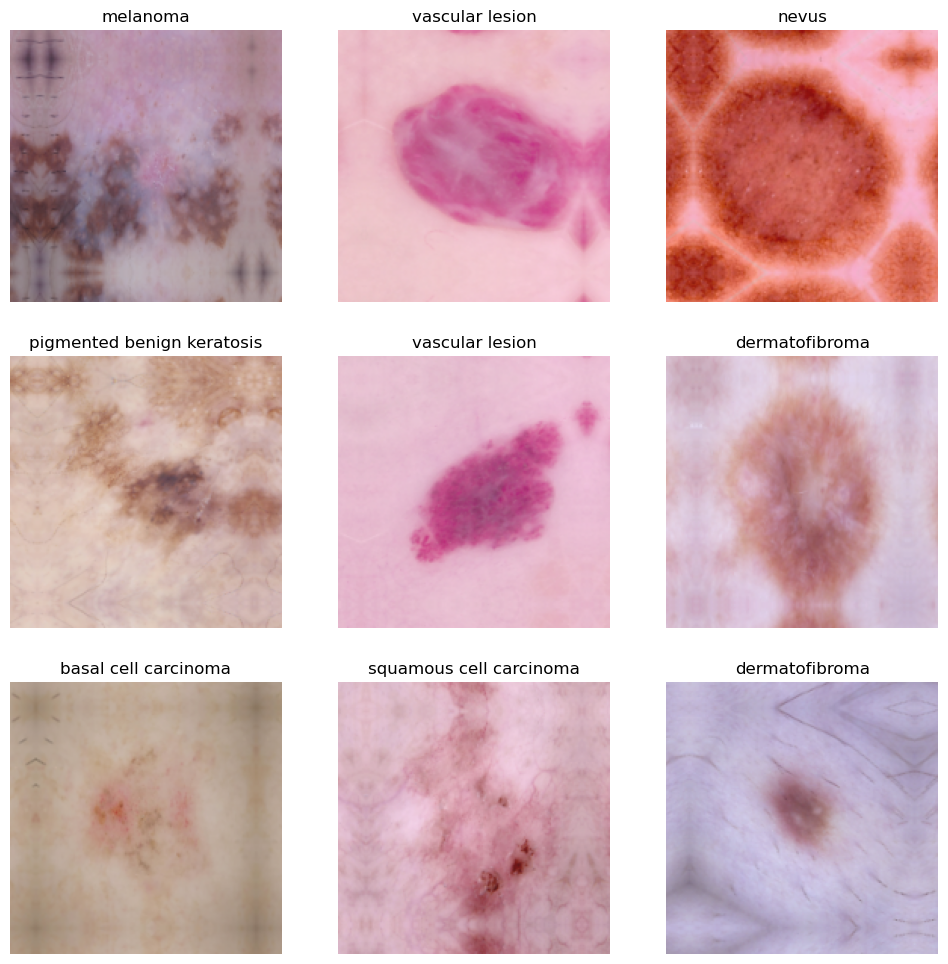

In [82]:
plt.figure(figsize=(12, 12))

# Assuming train_ds is your training dataset and class_names is a list of class names

# Take one batch from the training dataset
for images, labels in train_ds.take(1):
    # Apply data augmentation and plot the images
    augmented_images = data_augment(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.show()

### Create the model, compile and train the model

In [83]:
# Define the model
model = Sequential([
    data_augment,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  # Dropout rate of 0.25

    layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  # Dropout rate of 0.25

    layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  # Dropout rate of 0.25

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout rate of 0.5
    layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [84]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [85]:
# Define number of epochs
epochs = 20

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 122s 2s/step - loss: 2.1707 - accuracy: 0.1786 - val_loss: 2.0579 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 123s 2s/step - loss: 2.0424 - accuracy: 0.1886 - val_loss: 2.0419 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 124s 2s/step - loss: 2.0389 - accuracy: 0.2037 - val_loss: 2.0240 - val_accuracy: 0.2215
Epoch 4/20
56/56 [==============================] - 125s 2s/step - loss: 2.0103 - accuracy: 0.2383 - val_loss: 2.0430 - val_accuracy: 0.2036
Epoch 5/20
56/56 [==============================] - 124s 2s/step - loss: 1.9560 - accuracy: 0.2919 - val_loss: 1.7160 - val_accuracy: 0.4072
Epoch 6/20
56/56 [==============================] - 116s 2s/step - loss: 1.7924 - accuracy: 0.3722 - val_loss: 1.7464 - val_accuracy: 0.4407
Epoch 7/20
56/56 [==============================] - 118s 2s/step - loss: 1.6893 - accuracy: 0.4152 - val_loss: 1.5444 - val_accuracy: 0.4609
Epoch 8/20
56

### Visualizing the results

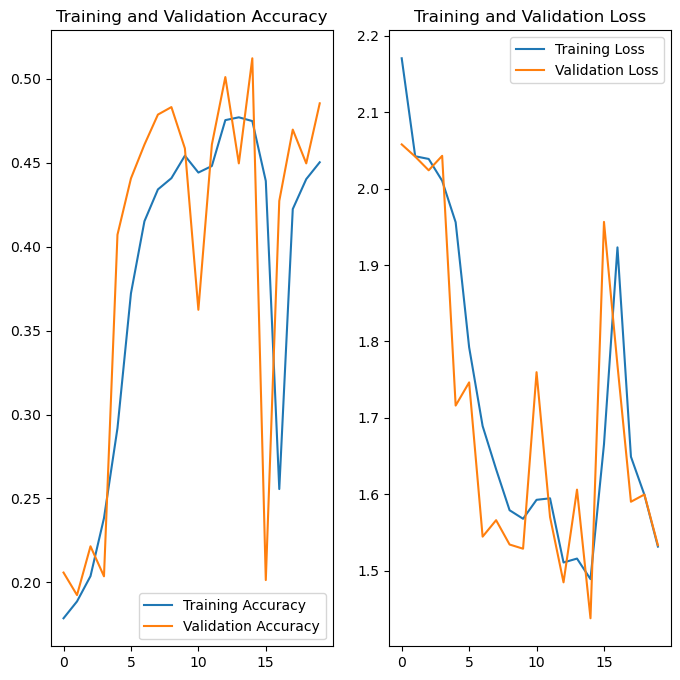

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Although we haven't observed a significant improvement in accuracy, the implementation of data augmentation has effectively addressed the overfitting issue. 

In [87]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

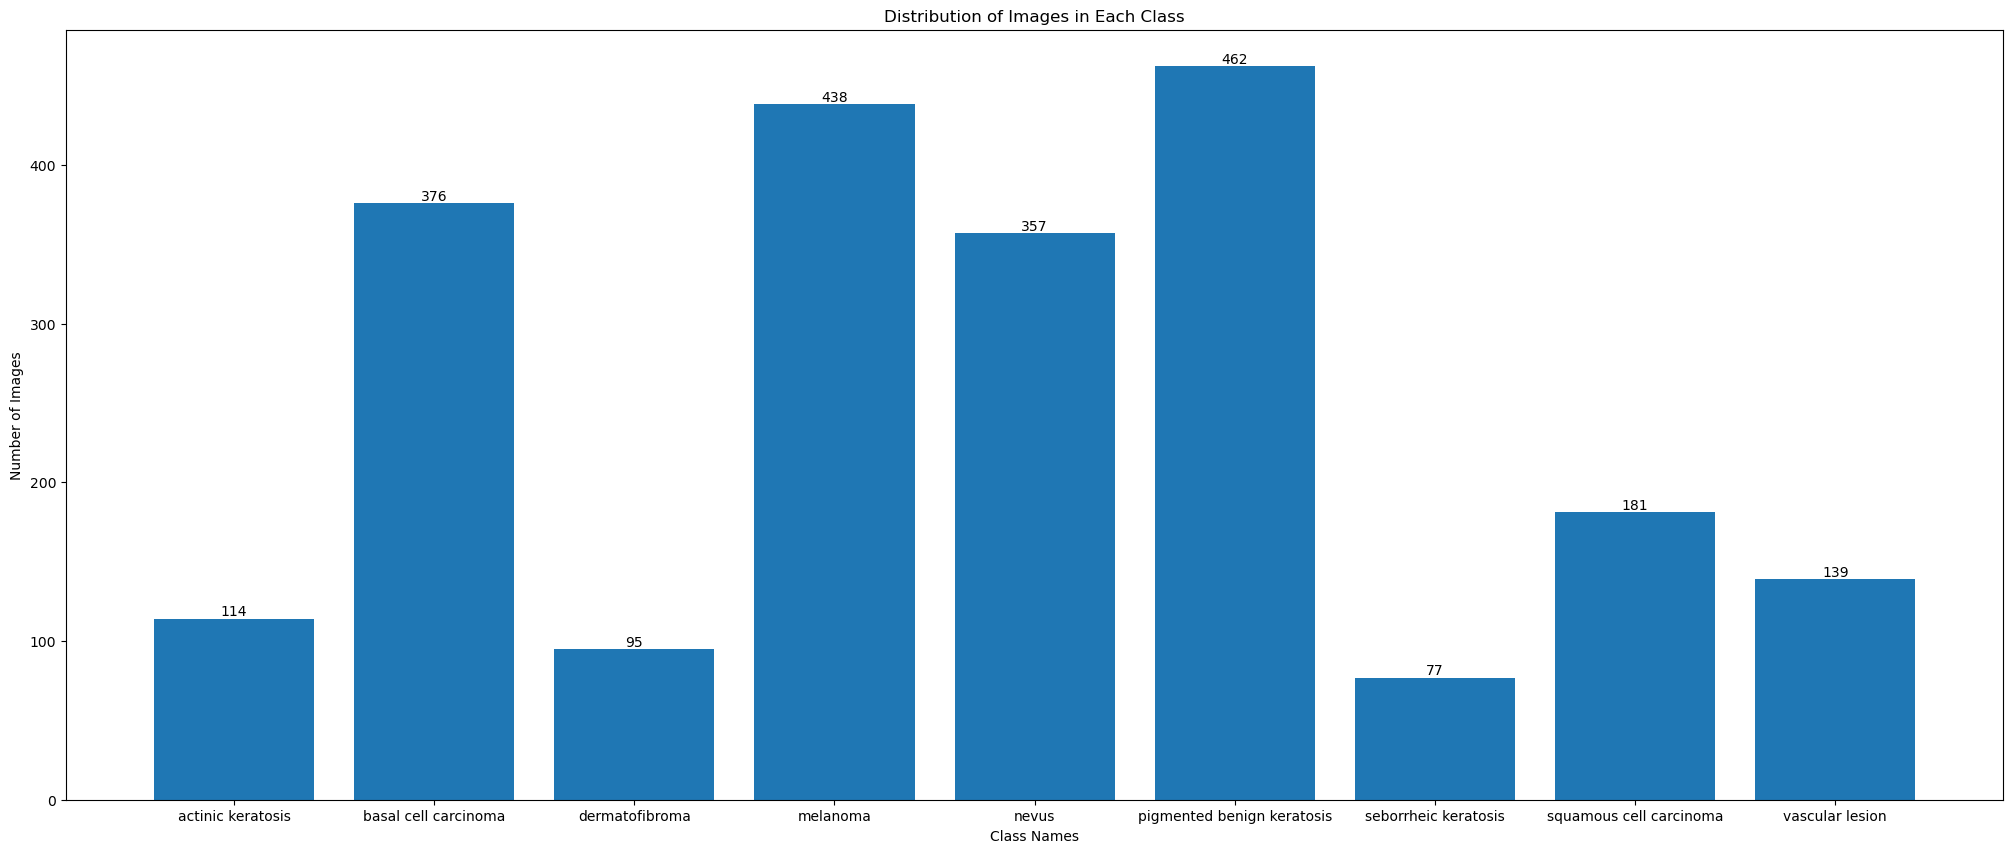

In [88]:
# Initialize a list to store the count of images in each class
count = []

# Iterate through each class
for class_name in class_names:
    # Count the number of images in the current class directory using glob
    image_count = len(list(data_dir_train.glob(f"{class_name}/*.jpg")))
    count.append(image_count)

plt.figure(figsize=(25, 10))
bars = plt.bar(class_names, count)

# Adding count values on top of each bar
for bar, value in zip(bars, count):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), value, ha='center', va='bottom')

plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Each Class')
plt.show()

#### - Which class has the least number of samples?
 Dermatofibroma and Seborrheic keratosis
 
#### - Which classes dominate the data in terms proportionate number of samples?
 Pigmented benign keratosis

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [89]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [161]:
path_to_training_dataset= pathlib.Path('Dataset/Train')

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset, save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to Dataset\Train\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1B68B07DD90>: 100%|█| 500/500 [00:14<00:


Initialised with 2239 image(s) found.
Output directory set to Dataset\Train\output.

Processing <PIL.Image.Image image mode=RGB size=1028x753 at 0x1B68467FC90>: 100%|█| 500/500 [00:13<00:00, 37.04 Samples


Initialised with 2239 image(s) found.
Output directory set to Dataset\Train\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1B67BE2E590>: 100%|█| 500/500 [00:14<00:00, 34.59 Samples


Initialised with 2239 image(s) found.
Output directory set to Dataset\Train\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1B68B06A7D0>: 100%|█| 500/500 [00:18<00:


Initialised with 2239 image(s) found.
Output directory set to Dataset\Train\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1B681276590>: 100%|█| 500/500 [00:16<00:00, 30.99 Samples


Initialised with 2239 image(s) found.
Output directory set to Dataset\Train\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1B67DEA9F50>: 100%|█| 500/500 [00:15<00


Initialised with 2239 image(s) found.
Output directory set to Dataset\Train\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1B68122BF90>: 100%|█| 500/500 [00:14<00:00, 34.13 Samples


Initialised with 2239 image(s) found.
Output directory set to Dataset\Train\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B684339450>: 100%|█| 500/500 [00:17<00:00, 28.75 Samples/


Initialised with 2239 image(s) found.
Output directory set to Dataset\Train\output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x1B5930E07D0>: 100%|█| 500/500 [00:18<00:00, 27.35 Sample


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [162]:
image_count_train = len(list(data_dir_train.glob('output/*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [7]:
import os
from glob import glob 
path_list = [x for x in glob(os.path.join(data_dir_train, 'output', '*', '*.jpg'))]
path_list

['Dataset\\Train\\output\\actinic keratosis\\actinic keratosis_original_ISIC_0025780.jpg_c5e5857a-0396-4aa4-a759-c11a9fa76681.jpg',
 'Dataset\\Train\\output\\actinic keratosis\\actinic keratosis_original_ISIC_0025803.jpg_a63e53d1-0d83-454a-93b2-b06bc8e38de7.jpg',
 'Dataset\\Train\\output\\actinic keratosis\\actinic keratosis_original_ISIC_0025825.jpg_31fc4713-5949-492c-963d-f7613265771e.jpg',
 'Dataset\\Train\\output\\actinic keratosis\\actinic keratosis_original_ISIC_0025953.jpg_65692cae-b797-427a-b828-a17d8818803e.jpg',
 'Dataset\\Train\\output\\actinic keratosis\\actinic keratosis_original_ISIC_0025953.jpg_696df4e9-193a-4048-936b-151eb200db3f.jpg',
 'Dataset\\Train\\output\\actinic keratosis\\actinic keratosis_original_ISIC_0025953.jpg_b8513002-9bbe-4e71-bb87-b9868e3b03fe.jpg',
 'Dataset\\Train\\output\\actinic keratosis\\actinic keratosis_original_ISIC_0025957.jpg_5ae6e529-8a3f-44bf-a52a-2b6a510975d0.jpg',
 'Dataset\\Train\\output\\actinic keratosis\\actinic keratosis_original_ISIC

In [8]:
#lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, 'output','*', '*.jpg'))]
#lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(str(data_dir_train), 'output', '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in data_dir_train.glob('output/**/*.jpg')]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [9]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [10]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [11]:
new_df

,Path,Label
0,Dataset\Train\output\actinic keratosis\actinic...,actinic keratosis
1,Dataset\Train\output\actinic keratosis\actinic...,actinic keratosis
2,Dataset\Train\output\actinic keratosis\actinic...,actinic keratosis
3,Dataset\Train\output\actinic keratosis\actinic...,actinic keratosis
4,Dataset\Train\output\actinic keratosis\actinic...,actinic keratosis
...,...,...
4495,Dataset\Train\output\vascular lesion\vascular ...,vascular lesion
4496,Dataset\Train\output\vascular lesion\vascular ...,vascular lesion
4497,Dataset\Train\output\vascular lesion\vascular ...,vascular lesion
4498,Dataset\Train\output\vascular lesion\vascular ...,vascular lesion


In [12]:
new_df['Label'].value_counts()

pigmented benign keratosis    927
melanoma                      876
basal cell carcinoma          737
nevus                         705
squamous cell carcinoma       398
vascular lesion               287
actinic keratosis             214
dermatofibroma                200
seborrheic keratosis          156
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####  Train the model on the data created using Augmentor

In [14]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [15]:
data_dir_train= pathlib.Path('Dataset/Train/output')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### Create a validation dataset

In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### Create your model (make sure to include normalization)

In [17]:
# Count the number of classes automatically from the dataset
num_classes = len(train_ds.class_names)

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  # Dropout rate of 0.25

    layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  # Dropout rate of 0.25

    layers.Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  # Dropout rate of 0.25

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout rate of 0.5
    layers.Dense(num_classes, activation='softmax')
])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        51264     
                                                      

####  Compile your model (Choose optimizer and loss function appropriately)

In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Train your model

In [19]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


113/113 [==============================] - 240s 2s/step - loss: 2.0795 - accuracy: 0.1936 - val_loss: 1.9631 - val_accuracy: 0.2367
Epoch 2/30
113/113 [==============================] - 240s 2s/step - loss: 2.0174 - accuracy: 0.2092 - val_loss: 1.9175 - val_accuracy: 0.2689
Epoch 3/30
113/113 [==============================] - 250s 2s/step - loss: 1.9537 - accuracy: 0.2653 - val_loss: 1.9101 - val_accuracy: 0.2844
Epoch 4/30
113/113 [==============================] - 245s 2s/step - loss: 1.8216 - accuracy: 0.3294 - val_loss: 1.7199 - val_accuracy: 0.3700
Epoch 5/30
113/113 [==============================] - 253s 2s/step - loss: 1.7350 - accuracy: 0.3636 - val_loss: 1.6313 - val_accuracy: 0.4044
Epoch 6/30
113/113 [==============================] - 264s 2s/step - loss: 1.6231 - accuracy: 0.3961 - val_loss: 1.5788 - val_accuracy: 0.4222
Epoch 7/30
113/113 [==============================] - 266s 2s/step - loss: 1.5418 - accuracy: 0.4408 - val_loss: 1.5330 - val_accuracy: 0.44

#### Visualize the model results

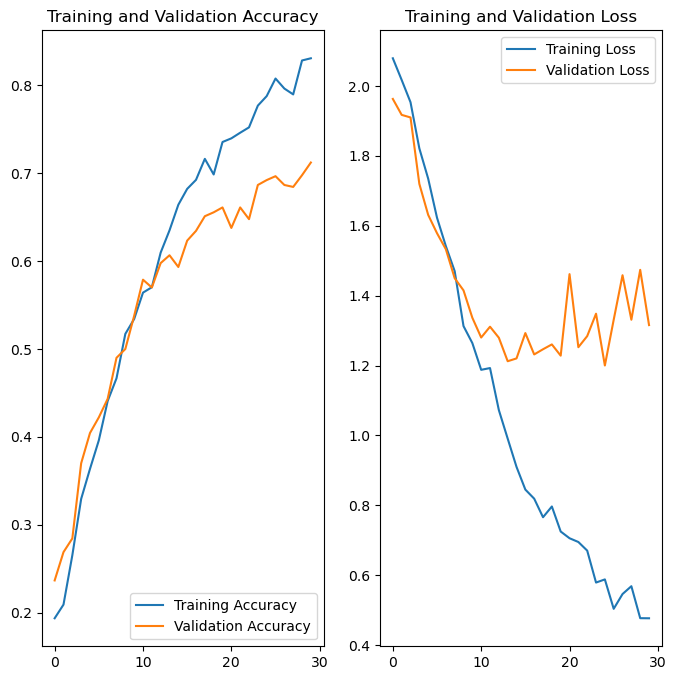

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- While implementing the Augmentor library, observed an increase in accuracy on the training data. However, despite this improvement, the model continues to suffer from overfitting.
- By augment the model architecture by adding more layers or neurons. This expanded complexity enables the model to capture additional nuances within the data, potentially reducing overfitting.